In [ ]:
# ✅ Install OpenCV
!apt-get update
!apt-get install -y libgl1-mesa-glx
!pip install opencv-python

# ✅ Install XGBoost
!pip install xgboost

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,701 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,863 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,543 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,154 kB]
Fetched 16.7 MB in 2s (9,213 kB/s)
Reading package lists... Done
W: Skipping acquire 

In [ ]:
# Import essential libraries
import numpy as np
import pandas as pd
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
# Path to the dataset folder (replace this with your dataset path)
dataset_path = "/content/drive/MyDrive/enhance_data"  # Use your Colab path

# Image dimensions
IMG_SIZE = 150

# Class labels
classes = ['glioma', 'meningioma', 'pituitary tumor', 'notumor']

# Data containers
data = []
labels = []

# Load and preprocess the images
print("\n📥 Loading and Preprocessing Dataset...")

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    # Iterating over all images in the class folder
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Load image in grayscale and resize it
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Normalize the image
        img = img / 255.0

        # Append image and label
        data.append(img.flatten())  # Flatten the image matrix into a vector
        labels.append(class_name)

print(f"✅ Loaded {len(data)} images with corresponding labels.")

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Shuffle dataset
combined = list(zip(X, y_encoded))
random.shuffle(combined)
X, y_encoded = zip(*combined)

# Convert back to numpy arrays
X = np.array(X)
y_encoded = np.array(y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Save the training and testing sets as CSV files
train_df = pd.DataFrame(X_train)
train_df['label'] = y_train
train_df.to_csv("/content/drive/MyDrive/training_dataset.csv", index=False)

test_df = pd.DataFrame(X_test)
test_df['label'] = y_test
test_df.to_csv("/content/drive/MyDrive/testing_dataset.csv", index=False)

print("\n✅ Dataset Preprocessing Completed!")
print(f"🔹 Training Set: {X_train.shape}")
print(f"🔹 Testing Set: {X_test.shape}")



📥 Loading and Preprocessing Dataset...
✅ Loaded 5104 images with corresponding labels.

✅ Dataset Preprocessing Completed!
🔹 Training Set: (4083, 22500)
🔹 Testing Set: (1021, 22500)


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle

# Define class labels
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]

# Load datasets
print("\n📥 Loading Training and Testing Datasets...")
train_df = pd.read_csv("/content/drive/MyDrive/training_dataset.csv")
test_df = pd.read_csv("/content/drive/MyDrive/testing_dataset.csv")

# Separate features and labels
X_train = train_df.drop("label", axis=1).values
y_train = train_df["label"].values
X_test = test_df.drop("label", axis=1).values
y_test = test_df["label"].values

# Shuffle training data to improve generalization
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Initialize models
models = {
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Train, test, save results and pickle each model
results = {}

print("\n🚀 Training and Testing Models...")

for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes)

    print(f"✅ {name} Accuracy: {acc:.4f}")

    # Prepare output DataFrame
    result_data = []
    for true, pred in zip(y_test, y_pred):
        result_data.append([
            1 if pred == "glioma" else 0,
            1 if pred == "meningioma" else 0,
            1 if pred == "pituitary" else 0,
            1 if pred == "no_tumor" else 0,
            true
        ])

    result_df = pd.DataFrame(result_data, columns=[
        "Class1 (Glioma)",
        "Class2 (Meningioma)",
        "Class3 (Pituitary)",
        "Class4 (Notumor)",
        "Ground_Truth"
    ])

    # Save to CSV
    result_df.to_csv(f"/content/drive/MyDrive/{name}_results.csv", index=False)

    # Save model using pickle
    with open(f"/content/drive/MyDrive/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

    results[name] = {
        "Accuracy": acc,
        "Report": report
    }

print("\n✅ Model Training, Testing and CSV Export Completed!")

# Display sample metrics
for name, res in results.items():
    print(f"\n🔹 {name} Summary:")
    print(f"Accuracy: {res['Accuracy']:.4f}")
    print(res['Report'])



📥 Loading Training and Testing Datasets...

🚀 Training and Testing Models...

🔹 Training DecisionTree...
✅ DecisionTree Accuracy: 0.8374

🔹 Training RandomForest...
✅ RandomForest Accuracy: 0.9305

🔹 Training KNN...
✅ KNN Accuracy: 0.8825

🔹 Training NaiveBayes...
✅ NaiveBayes Accuracy: 0.7640

🔹 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:21:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9461

✅ Model Training, Testing and CSV Export Completed!

🔹 DecisionTree Summary:
Accuracy: 0.8374
              precision    recall  f1-score   support

      glioma       0.76      0.79      0.77       287
  meningioma       0.66      0.61      0.64       144
   pituitary       0.99      0.98      0.98       404
    no_tumor       0.76      0.78      0.77       186

    accuracy                           0.84      1021
   macro avg       0.79      0.79      0.79      1021
weighted avg       0.84      0.84      0.84      1021


🔹 RandomForest Summary:
Accuracy: 0.9305
              precision    recall  f1-score   support

      glioma       0.88      0.90      0.89       287
  meningioma       0.81      0.86      0.84       144
   pituitary       1.00      1.00      1.00       404
    no_tumor       0.96      0.88      0.92       186

    accuracy                           0.93      1021
   macro avg       0.91      0.91      0.91      1021
weighted avg       0.

In [ ]:
import numpy as np
import pandas as pd

# ✅ Reverse mapping from integer to class label
int_to_label = {
    0: 'glioma',
    1: 'meningioma',
    2: 'pituitary',
    3: 'no_tumor'
}

# ✅ Class to one-hot encoding mapping
class_mapping = {
    'glioma': [1, 0, 0, 0],
    'meningioma': [0, 1, 0, 0],
    'pituitary': [0, 0, 1, 0],
    'no_tumor': [0, 0, 0, 1]
}

# ✅ Prepare the segregated dataset
seg_test_data = []
seg_test_labels = []

print("\n🚀 Preparing Segregated Test Dataset...")

# ✅ Match labels with corresponding images
for label in np.unique(y_test):
    indices = np.where(y_test == label)[0]
    class_name = int_to_label[int(label)]
    for idx in indices:
        # One-hot encoded row + label
        row = class_mapping[class_name]
        seg_test_data.append(row)
        seg_test_labels.append(class_name)

# ✅ Convert to DataFrame
seg_df = pd.DataFrame(seg_test_data, columns=['Class1_Glioma', 'Class2_Meningioma', 'Class3_Pituitary', 'Class4_NoTumor'])
seg_df['Ground_Truth'] = seg_test_labels

# ✅ Save to CSV
seg_df.to_csv("/content/drive/MyDrive/segregated_test_dataset.csv", index=False)

print("\n✅ Corrected Segregated Dataset Saved Successfully!")
print(f"🔹 Shape: {seg_df.shape}")
print(f"🔹 Columns: {seg_df.columns.tolist()}")



🚀 Preparing Segregated Test Dataset...

✅ Corrected Segregated Dataset Saved Successfully!
🔹 Shape: (1021, 5)
🔹 Columns: ['Class1_Glioma', 'Class2_Meningioma', 'Class3_Pituitary', 'Class4_NoTumor', 'Ground_Truth']


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# ✅ Class labels
classes = ["Glioma", "Meningioma", "Pituitary", "NoTumor"]

print("\n📥 Loading Original Test Dataset (Image Features)...")

# ✅ Load the original testing dataset
original_test_df = pd.read_csv("/content/drive/MyDrive/testing_dataset.csv")

# ✅ Separate features and labels
X_test = original_test_df.drop("label", axis=1).values
y_test = original_test_df["label"].values

print(f"🔹 Features shape: {X_test.shape}")
print(f"🔹 Labels shape: {y_test.shape}")

# ✅ Load trained models from pickle files
print("\n📦 Loading Pickled Models...")
model_paths = {
    "DecisionTree": "/content/drive/MyDrive/DecisionTree_model.pkl",
    "RandomForest": "/content/drive/MyDrive/RandomForest_model.pkl",
    "KNN": "/content/drive/MyDrive/KNN_model.pkl",
    "NaiveBayes": "/content/drive/MyDrive/NaiveBayes_model.pkl",
    "XGBoost": "/content/drive/MyDrive/XGBoost_model.pkl"
}

models = {}
for name, path in model_paths.items():
    with open(path, "rb") as file:
        models[name] = pickle.load(file)
        print(f"✅ Loaded {name} model from {path}")

# ✅ Dictionary to store evaluation results
results = {}

print("\n🚀 Evaluating Models on Original Test Dataset...")

# ✅ Evaluate each model
for name, model in models.items():
    print(f"\n🔹 Testing {name}...")

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy and report
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes)

    print(f"✅ {name} Accuracy: {acc:.4f}")

    # ✅ Convert predictions to one-hot encoding
    one_hot_pred = np.zeros((len(y_pred), 4), dtype=int)
    one_hot_pred[np.arange(len(y_pred)), y_pred] = 1

    # ✅ Create final result DataFrame with required columns
    final_result_df = pd.DataFrame(one_hot_pred, columns=[
        "Class1_Glioma",
        "Class2_Meningioma",
        "Class3_Pituitary",
        "Class4_NoTumor"
    ])
    final_result_df["Ground_Truth"] = y_test

    # ✅ Save to CSV
    final_result_df.to_csv(f"/content/drive/MyDrive/{name}_final_test_results.csv", index=False)

    # Store metrics
    results[name] = {
        "Accuracy": acc,
        "Report": report
    }

# ✅ Display all results
print("\n✅ Final Model Evaluation Completed!")
for name, res in results.items():
    print(f"\n🔹 {name} Results:")
    print(f"Accuracy: {res['Accuracy']:.4f}")
    print(res['Report'])



📥 Loading Original Test Dataset (Image Features)...
🔹 Features shape: (1021, 22500)
🔹 Labels shape: (1021,)

📦 Loading Pickled Models...
✅ Loaded DecisionTree model from /content/drive/MyDrive/DecisionTree_model.pkl
✅ Loaded RandomForest model from /content/drive/MyDrive/RandomForest_model.pkl
✅ Loaded KNN model from /content/drive/MyDrive/KNN_model.pkl
✅ Loaded NaiveBayes model from /content/drive/MyDrive/NaiveBayes_model.pkl
✅ Loaded XGBoost model from /content/drive/MyDrive/XGBoost_model.pkl

🚀 Evaluating Models on Original Test Dataset...

🔹 Testing DecisionTree...
✅ DecisionTree Accuracy: 0.8374

🔹 Testing RandomForest...
✅ RandomForest Accuracy: 0.9305

🔹 Testing KNN...
✅ KNN Accuracy: 0.8825

🔹 Testing NaiveBayes...
✅ NaiveBayes Accuracy: 0.7640

🔹 Testing XGBoost...
✅ XGBoost Accuracy: 0.9461

✅ Final Model Evaluation Completed!

🔹 DecisionTree Results:
Accuracy: 0.8374
              precision    recall  f1-score   support

      Glioma       0.76      0.79      0.77       287

<ipython-input-13-1373440f4940>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='coolwarm')


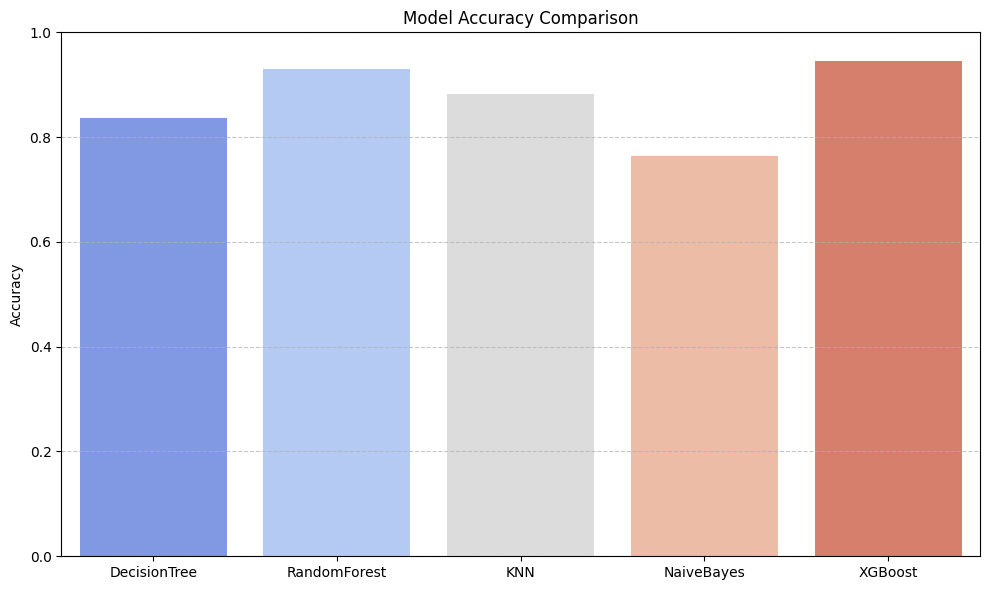

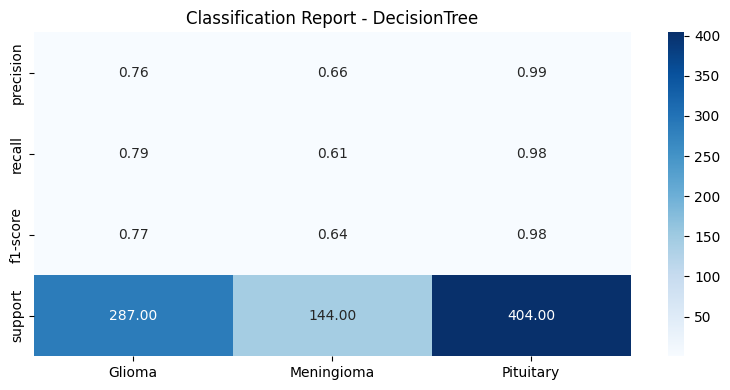

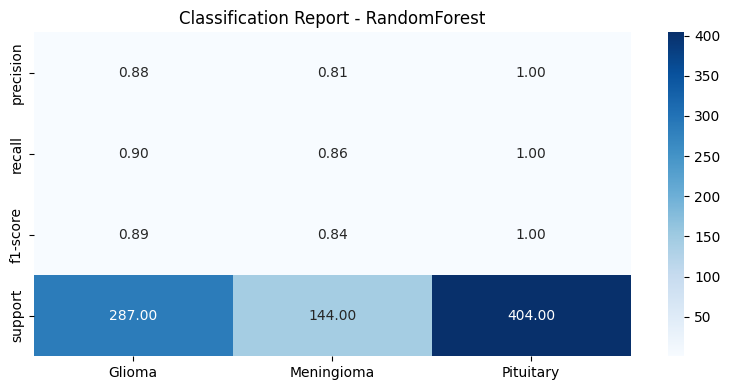

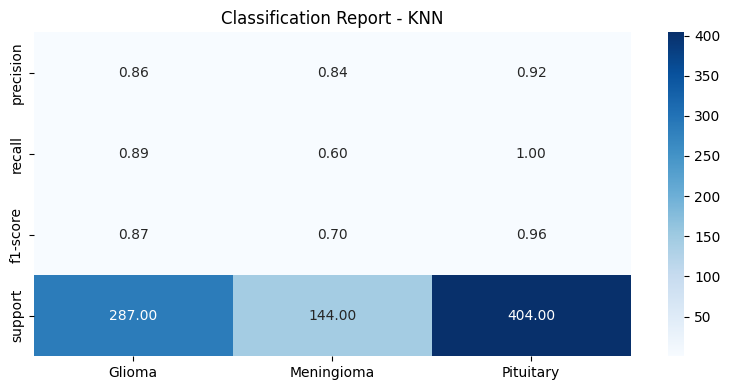

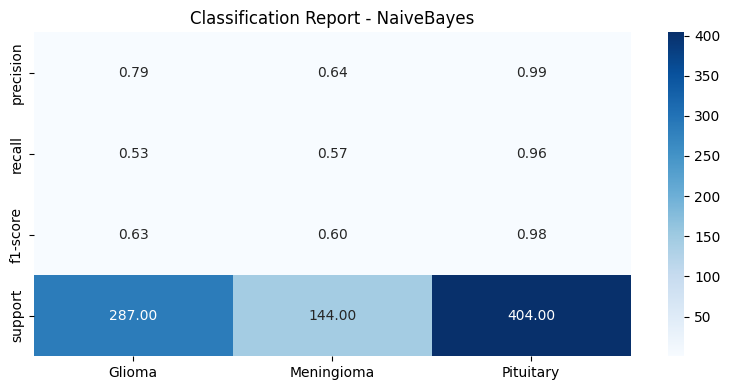

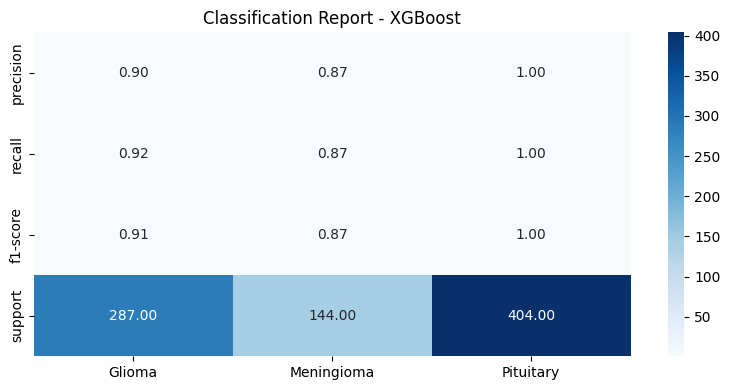

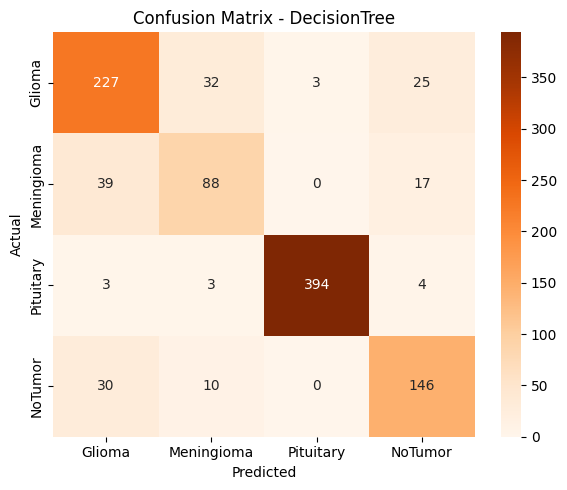

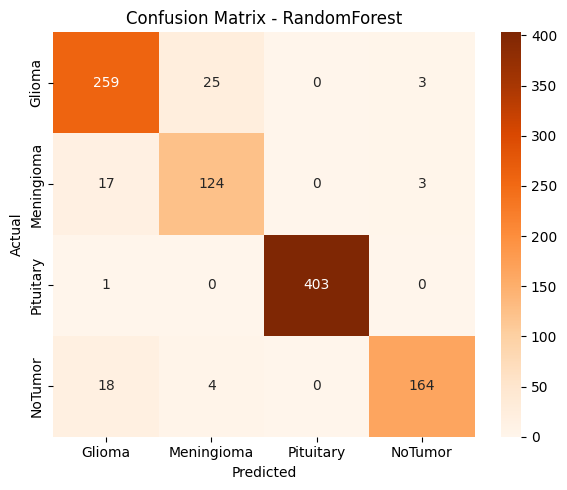

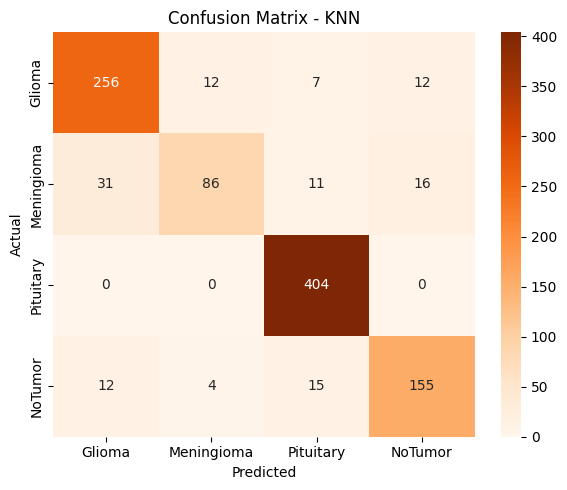

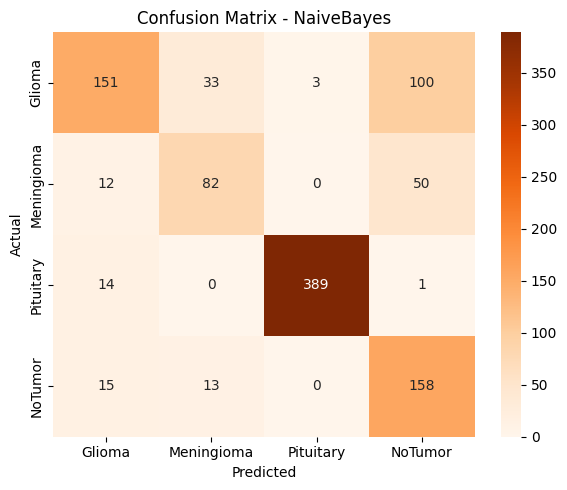

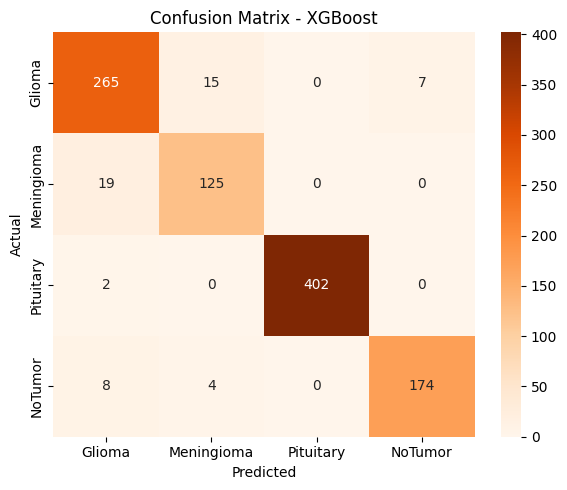

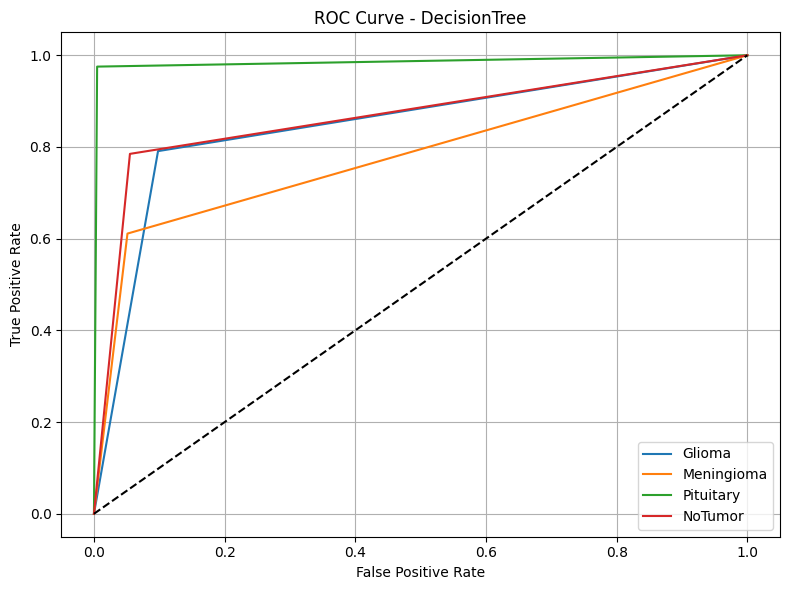

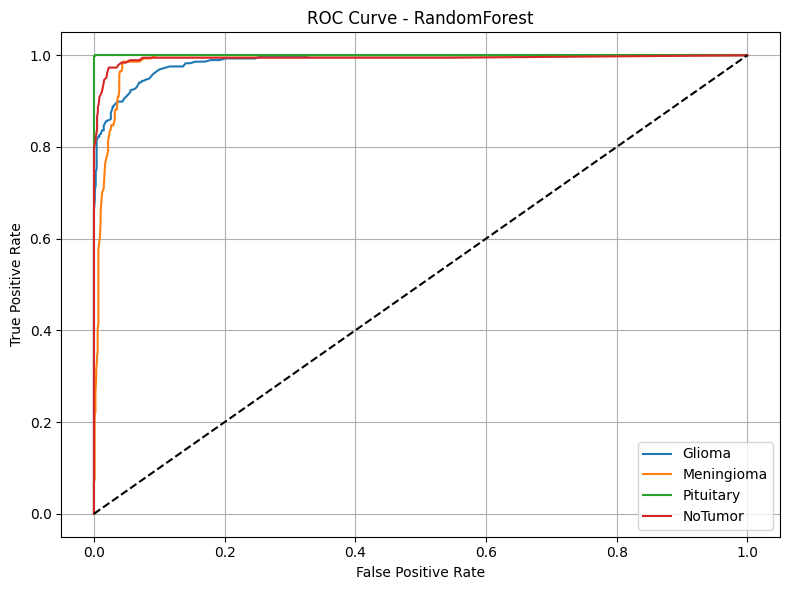

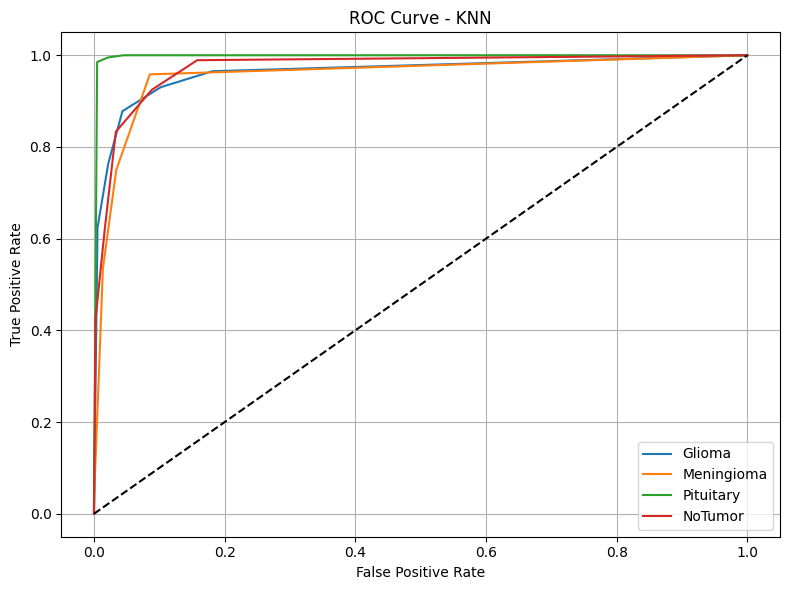

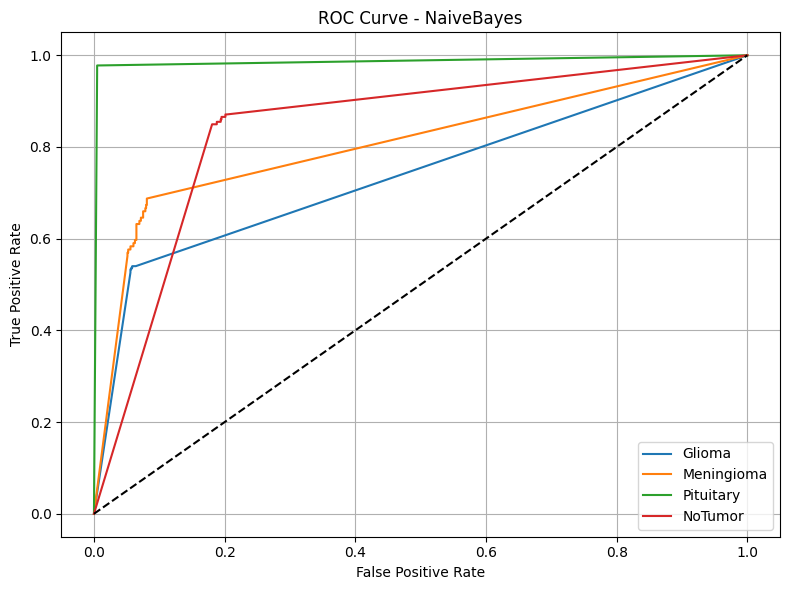

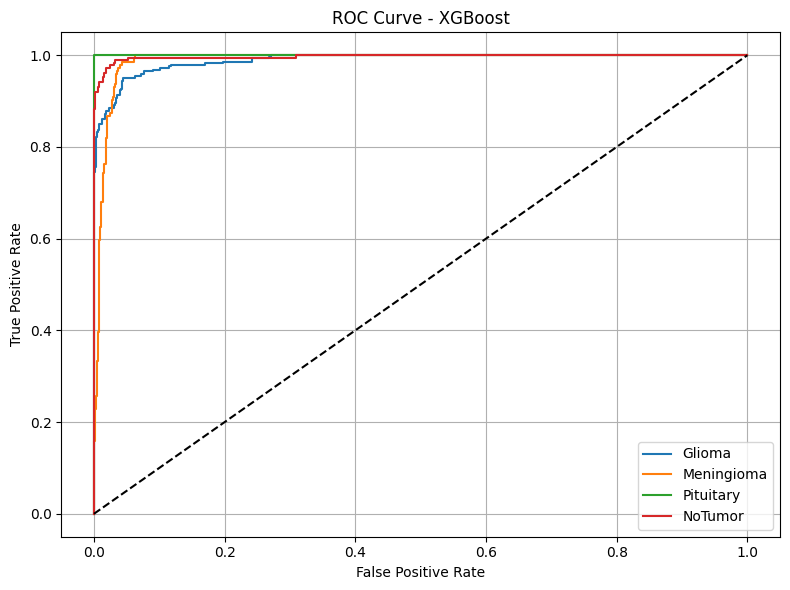

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

# Convert labels to binary format for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Assuming 0-Glioma, ..., 3-NoTumor
n_classes = y_test_bin.shape[1]

# Bar Chart: Accuracy Comparison
model_names = []
accuracies = []
all_reports = {}

for name, model in models.items():
    model_names.append(name)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    all_reports[name] = report_dict

# 📊 Accuracy Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='coolwarm')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 🔍 Classification Report Heatmaps
for name in model_names:
    plt.figure(figsize=(8, 4))
    report_df = pd.DataFrame(all_reports[name]).iloc[:4, :3]  # Class-wise only
    sns.heatmap(report_df, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"Classification Report - {name}")
    plt.tight_layout()
    plt.show()

# 🔁 Confusion Matrix for Each Model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# 🧠 ROC Curves for Models (Only if predict_proba is available)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{classes[i]}")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n⚠️ Skipping ROC for {name} (no predict_proba available)")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

# ✅ Correct class names
classes = ["Glioma", "Meningioma", "Pituitary", "NoTumor"]
class_columns = [
    "Class1_Glioma",
    "Class2_Meningioma",
    "Class3_Pituitary",
    "Class4_NoTumor"
]

# ✅ Load prediction CSVs from all models
model_csvs = {
    "DecisionTree": "/content/drive/MyDrive/DecisionTree_final_test_results.csv",
    "RandomForest": "/content/drive/MyDrive/RandomForest_final_test_results.csv",
    "KNN": "/content/drive/MyDrive/KNN_final_test_results.csv",
    "NaiveBayes": "/content/drive/MyDrive/NaiveBayes_final_test_results.csv",
    "XGBoost": "/content/drive/MyDrive/XGBoost_final_test_results.csv"
}

# ✅ Load predictions into dictionary
model_preds = {}
for name, path in model_csvs.items():
    df = pd.read_csv(path)
    preds = df[class_columns].idxmax(axis=1).apply(lambda x: x.split('_')[1])
    preds = preds.replace({
        "NoTumor": "NoTumor",  # make sure spelling matches
        "Notumor": "NoTumor"   # fix possible typo
    })
    model_preds[name] = preds.tolist()

# ✅ Load and convert Ground Truth
ground_truth_numeric = pd.read_csv(model_csvs["DecisionTree"])["Ground_Truth"].tolist()
ground_truth = [classes[int(i)] for i in ground_truth_numeric]

# ✅ Perform QNBC Voting
ensemble_preds = []
for i in range(len(ground_truth)):
    votes = [model_preds[model][i] for model in model_csvs]
    vote_result = Counter(votes).most_common(1)[0][0]
    ensemble_preds.append(vote_result)

# ✅ Debug: Check unique labels
print("Unique labels in Ground Truth:", set(ground_truth))
print("Unique labels in Predictions:", set(ensemble_preds))

# ✅ Evaluate Ensemble
acc = accuracy_score(ground_truth, ensemble_preds)
report = classification_report(ground_truth, ensemble_preds, target_names=classes)

print(f"\n✅ QNBC Ensemble Accuracy: {acc:.4f}")
print("\n📊 Classification Report:")
print(report)

# ✅ Save results
ensemble_df = pd.DataFrame({
    "Class1_Glioma": [1 if p == "Glioma" else 0 for p in ensemble_preds],
    "Class2_Meningioma": [1 if p == "Meningioma" else 0 for p in ensemble_preds],
    "Class3_Pituitary": [1 if p == "Pituitary" else 0 for p in ensemble_preds],
    "Class4_NoTumor": [1 if p == "NoTumor" else 0 for p in ensemble_preds],
    "Ground_Truth": ground_truth
})

ensemble_df.to_csv("/content/drive/MyDrive/QNBC_ensemble_results.csv", index=False)
print("\n✅ QNBC Ensemble Results saved to: QNBC_ensemble_results.csv")


Unique labels in Ground Truth: {'NoTumor', 'Glioma', 'Meningioma', 'Pituitary'}
Unique labels in Predictions: {'NoTumor', 'Glioma', 'Meningioma', 'Pituitary'}

✅ QNBC Ensemble Accuracy: 0.9373

📊 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.91      0.90      0.90       287
  Meningioma       0.82      0.85      0.84       144
   Pituitary       0.94      0.92      0.93       186
     NoTumor       1.00      1.00      1.00       404

    accuracy                           0.94      1021
   macro avg       0.92      0.92      0.92      1021
weighted avg       0.94      0.94      0.94      1021


✅ QNBC Ensemble Results saved to: QNBC_ensemble_results.csv
